In [1]:
# Install required libraries if not already installed
#!pip install tensorflow opencv-python matplotlib scikit-learn

# Import necessary libraries
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# Define dataset paths
dataset_path = "/kaggle/input/unet-dataset/Project/potato_dataset_downloaded"  # Replace with the actual path
mask_path = "/kaggle/input/unet-dataset/Project/mask_merged"  # Replace with the actual path

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
TEST_SPLIT = 0.2
VAL_SPLIT = 0.1


In [3]:
def load_images(folder):
    images = []
    for subfolder in ["E_B", "L_B", "Healthy"]:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in sorted(os.listdir(subfolder_path)):
            if filename.endswith(".jpg") or filename.endswith(".JPG"):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0  # Normalize pixel values
                images.append(img)
    return np.array(images)


In [4]:
'''
def load_masks(folder):
    masks = []
    for subfolder in ["E_B", "L_B", "Healthy"]:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in sorted(os.listdir(subfolder_path)):
            if filename.endswith(".jpg") or filename.endswith(".JPG"):
                mask_path = os.path.join(subfolder_path, filename)
                mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                mask_array = img_to_array(mask)

                # Identify foreground pixels (any pixel other than [0, 0, 0])
                foreground = np.any(mask_array != [0, 0, 0], axis=-1)

                # Convert to binary mask (1 for foreground, 0 for background)
                binary_mask = np.where(foreground, 1, 0)

                masks.append(binary_mask)

    return np.array(masks)

'''


'\ndef load_masks(folder):\n    masks = []\n    for subfolder in ["E_B", "L_B", "Healthy"]:\n        subfolder_path = os.path.join(folder, subfolder)\n        for filename in sorted(os.listdir(subfolder_path)):\n            if filename.endswith(".jpg") or filename.endswith(".JPG"):\n                mask_path = os.path.join(subfolder_path, filename)\n                mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH))\n                mask_array = img_to_array(mask)\n\n                # Identify foreground pixels (any pixel other than [0, 0, 0])\n                foreground = np.any(mask_array != [0, 0, 0], axis=-1)\n\n                # Convert to binary mask (1 for foreground, 0 for background)\n                binary_mask = np.where(foreground, 1, 0)\n\n                masks.append(binary_mask)\n\n    return np.array(masks)\n\n'

In [5]:
#Function to load the masks: foreground is marked by a higher value of red in channel
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_masks(folder):
    masks = []
    for subfolder in ["E_B", "L_B", "Healthy"]:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in sorted(os.listdir(subfolder_path)):
            if filename.endswith(".jpg") or filename.endswith(".JPG"):
                mask_path = os.path.join(subfolder_path, filename)
                mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                mask_array = img_to_array(mask)
                
                # Assuming that red indicates the foreground (high value in the red channel)
                # The foreground is marked by a high value in the red channel (R > G and B)
                foreground = (mask_array[:,:,0] > 100) & (mask_array[:,:,1] < 50) & (mask_array[:,:,2] < 50)
                
                # Convert to binary mask (1 for foreground, 0 for background)
                binary_mask = foreground.astype(np.uint8)
                unique_values = np.unique(binary_mask)
                #print(f"Unique values in mask {filename}: {unique_values}")

                masks.append(binary_mask)

    return np.array(masks)



In [6]:
# Load images and masks
images = load_images(dataset_path)
masks = load_masks(mask_path)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=TEST_SPLIT + VAL_SPLIT, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=TEST_SPLIT / (TEST_SPLIT + VAL_SPLIT), random_state=42)

print(f"Train set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")


Train set size: 1506, Validation set size: 215, Test set size: 431


In [7]:
def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [8]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = tf.keras.layers.Input(input_size)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [9]:
# Compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32)


Epoch 1/200


I0000 00:00:1732989653.267510      98 service.cc:145] XLA service 0x7bd4740159d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732989653.267587      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732989690.701954      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 735ms/step - accuracy: 0.7962 - loss: 0.4248 - val_accuracy: 0.8730 - val_loss: 0.3160
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.8734 - loss: 0.3038 - val_accuracy: 0.9112 - val_loss: 0.2334
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.8977 - loss: 0.2556 - val_accuracy: 0.9056 - val_loss: 0.2340
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9063 - loss: 0.2376 - val_accuracy: 0.9082 - val_loss: 0.2361
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9111 - loss: 0.2371 - val_accuracy: 0.9253 - val_loss: 0.2051
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9129 - loss: 0.2226 - val_accuracy: 0.9012 - val_loss: 0.2370
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9095 - loss: 0.2238 - val_accuracy: 0.9280 - val_loss: 0.1856
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.9206 - loss: 0.2107 - val_accuracy

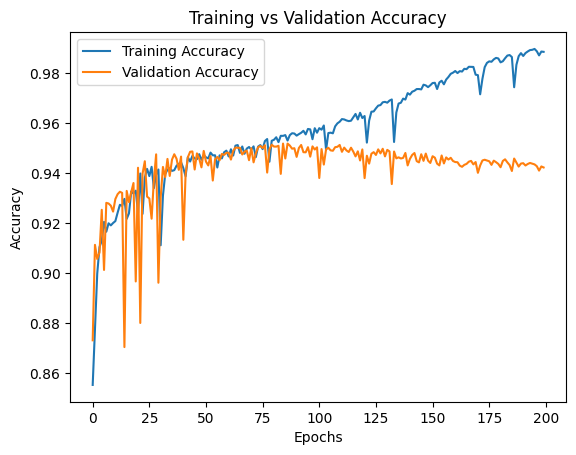

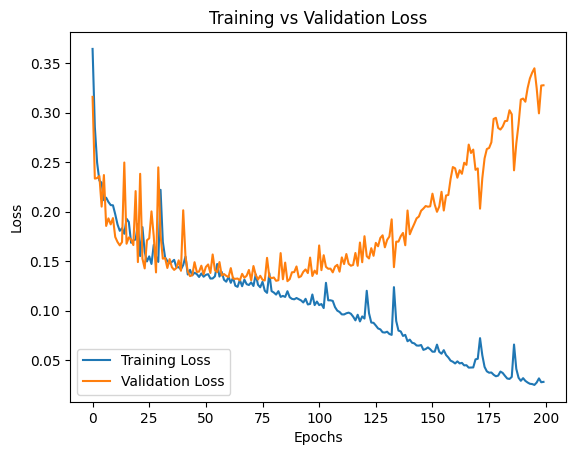

In [10]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 664ms/step


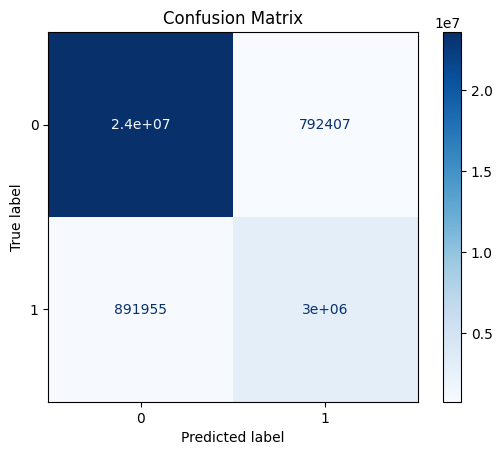

Mean IoU: 0.6394908153055054
Dice Coefficient: 0.7801090550011306
Pixel Accuracy: 0.9403681566986296
Testing Accuracy: 94.04%


In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate on test set
y_pred = (model.predict(X_test) > 0.5).astype(np.uint8)

# Flatten all test masks and predictions
y_test_flat = np.concatenate([y.flatten() for y in y_test])
y_pred_flat = np.concatenate([y.flatten() for y in y_pred])

# Compute a single confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Compute metrics
iou = mean_iou(y_test_flat, y_pred_flat)
dice = dice_coefficient(y_test_flat, y_pred_flat)
accuracy = pixel_accuracy(y_test_flat, y_pred_flat)

# Compute Testing Accuracy
correct_predictions = np.sum(y_test_flat == y_pred_flat)
total_pixels = y_test_flat.size
testing_accuracy = correct_predictions / total_pixels * 100

# Print metrics
print(f"Mean IoU: {iou}")
print(f"Dice Coefficient: {dice}")
print(f"Pixel Accuracy: {accuracy}")
print(f"Testing Accuracy: {testing_accuracy:.2f}%")


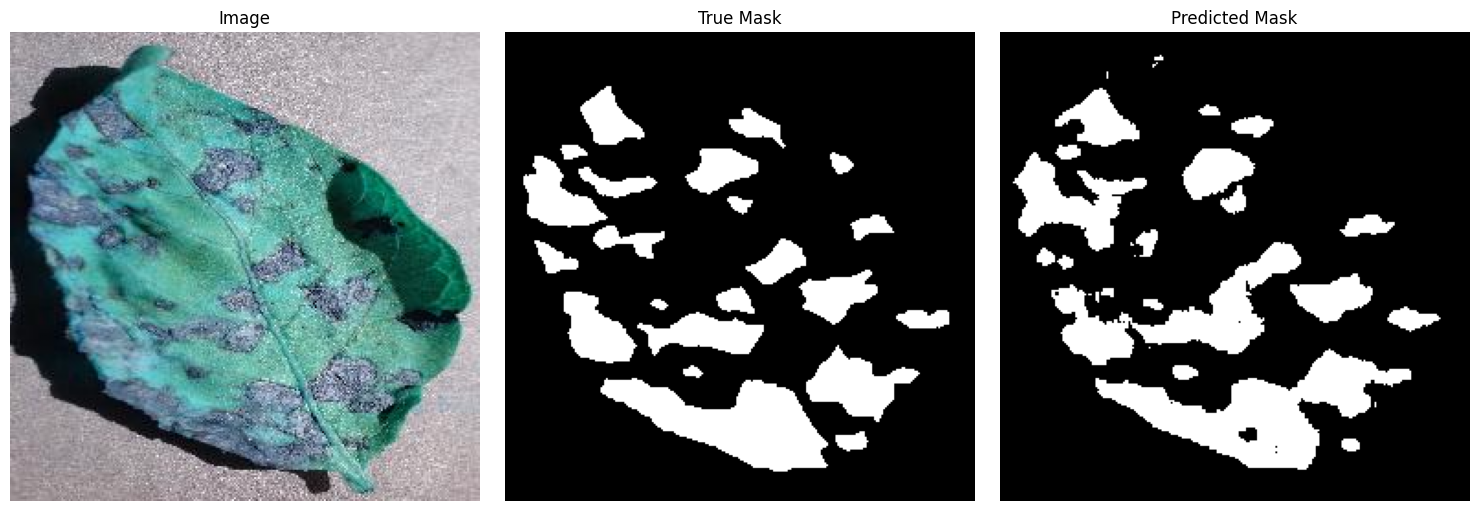

In [14]:
import matplotlib.pyplot as plt

# Choose an image index (for example, the first image in the test set)
index = 16

# Get the image, its corresponding mask, and the prediction
image = X_test[index]  # The input image (e.g., 256x256)
true_mask = y_test[index]  # The true mask (e.g., 256x256)
predicted_mask = (y_pred[index] > 0.5).astype(np.uint8)  # The predicted mask (e.g., 256x256)

# Plot the image, its mask, and its prediction
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Image
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

# Mask
axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title("True Mask")
axes[1].axis("off")

# Prediction
axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()